In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ast import literal_eval
import re
import itertools

pd.set_option("max_columns", 100)

# Steam Categories

For this project I am looking at 1000 rows of data I have downloaded from Steam's API and I am trying to see if there is any categories that are most reconmended by Steam users.

## Set up the file for use

So lets get started taking a look at my file

In [2]:
steam_raw = pd.read_csv('.\Data\steam_app_data.csv')

In [3]:
# Check to see what columns have the most Null values
steam_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type                     999 non-null    object 
 1   name                     1000 non-null   object 
 2   steam_appid              1000 non-null   int64  
 3   required_age             999 non-null    object 
 4   is_free                  999 non-null    object 
 5   controller_support       363 non-null    object 
 6   dlc                      508 non-null    object 
 7   detailed_description     999 non-null    object 
 8   about_the_game           999 non-null    object 
 9   short_description        999 non-null    object 
 10  fullgame                 0 non-null      float64
 11  supported_languages      999 non-null    object 
 12  header_image             999 non-null    object 
 13  website                  877 non-null    object 
 14  pc_requirements          

In [4]:
# Lets take a peek at how the dataset looks like
steam_raw.head()

,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,short_description,fullgame,supported_languages,header_image,website,pc_requirements,mac_requirements,linux_requirements,legal_notice,drm_notice,ext_user_account_notice,developers,publishers,demos,price_overview,packages,package_groups,platforms,metacritic,reviews,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors
0,game,Counter-Strike,10,0,False,NaN,NaN,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,NaN,"English<strong>*</strong>, French<strong>*</st...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",NaN,NaN,NaN,['Valve'],['Valve'],NaN,"{'currency': 'CAD', 'initial': 1149, 'final': ...","[574941, 7]","[{'name': 'default', 'title': 'Buy Counter-Str...","{'windows': True, 'mac': True, 'linux': True}","{'score': 88, 'url': 'https://www.metacritic.c...",NaN,"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 124964},NaN,"{'coming_soon': False, 'date': '1 Nov, 2000'}","{'url': 'http://steamcommunity.com/app/10', 'e...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [2, 5], 'notes': 'Includes intense vio..."
1,game,Team Fortress Classic,20,0,False,NaN,NaN,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,NaN,"English, French, German, Italian, Spanish - Sp...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",NaN,NaN,NaN,['Valve'],['Valve'],NaN,"{'currency': 'CAD', 'initial': 569, 'final': 5...",[29],"[{'name': 'default', 'title': 'Buy Team Fortre...","{'windows': True, 'mac': True, 'linux': True}",NaN,NaN,"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 4848},NaN,"{'coming_soon': False, 'date': '1 Apr, 1999'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [2, 5], 'notes': 'Includes intense vio..."
2,game,Day of Defeat,30,0,False,NaN,NaN,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,NaN,"English, French, German, Italian, Spanish - Spain",https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.dayofdefeat.com/,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimum: OS X Snow Leopard 10.6....,"{'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...",NaN,NaN,NaN,['Valve'],['Valve'],NaN,"{'currency': 'CAD', 'initial': 569, 'final': 5...",[30],"[{'name': 'default', 'title': 'Buy Day of Defe...","{'windows': True, 'mac': True, 'linux': True}","{'score': 79, 'url': 'https://www.metacritic.c...",NaN,"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 3294},NaN,"{'coming_soon': False, 'date': '1 May, 2003'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
3,game,Deathmatch Classic,40,0,False,NaN,NaN,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,NaN,"English, French, German, Italian, Spanish - Sp...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,{'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...,{'minimum': 'Minimu

In [5]:
# remove the unnecessary columns. I am not analyzing these columns so lets make the table smaller and cleaner
colsDelSteam = ['controller_support', 'dlc', 'detailed_description', 'about_the_game', 'short_description', 'fullgame', 'header_image', 'website', 'pc_requirements', 'mac_requirements', 'linux_requirements',
       'legal_notice', 'drm_notice', 'demos', 'platforms', 'screenshots', 'movies', 'support_info', 'background', 'content_descriptors', 'ext_user_account_notice', 'supported_languages', 'required_age',
        'packages', 'package_groups', 'metacritic', 'reviews', 'achievements', 'release_date']

steam_raw = steam_raw.drop(colsDelSteam, axis=1)

In [6]:
# Okay now that the uneeded columns are gone lets see how many Null values I have left
steam_raw.isna().sum()

type                 1
name                 0
steam_appid          0
is_free              1
developers           2
publishers           1
price_overview     259
categories           4
genres               4
recommendations    105
dtype: int64

In [7]:
# Just checking to make sure I have all my rows still
steam_raw.shape[0]

1000

## Data Cleaning

Here I am checking to see if there are any rows that have a missing value in the type column as that tells me it has incomplete data. I am also checking to see if I have any identical rows of data.

In [8]:
print('Rows to remove:', steam_raw[steam_raw['type'].isnull()].shape[0])

# preview rows with missing type data
steam_raw[steam_raw['type'].isnull()].head(3)

Rows to remove: 1


,type,name,steam_appid,is_free,developers,publishers,price_overview,categories,genres,recommendations
772,NaN,Digimon Masters Online,537180,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
steam_raw[(steam_raw['name'].isnull()) | (steam_raw['name'] == 'none')]

,type,name,steam_appid,is_free,developers,publishers,price_overview,categories,genres,recommendations


In [10]:
identical_rows = steam_raw[steam_raw.duplicated()]

print('Identical rows to remove:', identical_rows.shape[0])

identical_rows.head()

Identical rows to remove: 0


,type,name,steam_appid,is_free,developers,publishers,price_overview,categories,genres,recommendations


Now that I have identified all the rows needing to be removed, I will remove them now.

In [11]:
steam_raw.dropna(
    axis=0,
    how='any',
    thresh=5,
    subset=None,
    inplace=True
)
steam_raw.shape[0]

999

In [12]:
# sanity check to see if the identifed row is gone
steam_raw.loc[steam_raw['name'] == 'Digimon Masters Online']

,type,name,steam_appid,is_free,developers,publishers,price_overview,categories,genres,recommendations


Okay lets start at unpacking the price column and cleaning rows that have missing price data

In [13]:
# see how many Nulls I have in the row
steam_raw['price_overview'].isnull().sum()

258

Remembering that some Steam games are Free-to-play I am identifying how many rows of data are free and have missing price data

In [14]:
price_cleaning = steam_raw[(steam_raw['is_free']) & (steam_raw['price_overview'].isnull())]
price_cleaning.shape[0]

182

In [15]:
# checking to see what the column is built like so I know how to unpack it
steam_raw['price_overview'][0]

"{'currency': 'CAD', 'initial': 1149, 'final': 1149, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'CDN$ 11.49'}"

Here I am creating a function so that I can unpacking the price and create a column that only has the price in number form that we are used to seeing as x.xx

In [16]:
def find_price(steam_raw):
    steam_raw = steam_raw.copy()
        
    def analyze_price(x):
        if x is not np.nan:
            return literal_eval(x)
        else:
            return {'currency': 'CAD', 'initial': -1}
    
    # evaluate as dictionary and set to -1 if missing
    steam_raw['price_overview'] = steam_raw['price_overview'].apply(analyze_price)
    
    # Create columns from currency and initial values
    steam_raw['currency'] = steam_raw['price_overview'].apply(lambda x: x['currency'])
    steam_raw['price'] = steam_raw['price_overview'].apply(lambda x: x['initial'])
    
    # Set price of free games to 0
    steam_raw.loc[steam_raw['is_free'], 'price'] = 0
    
    # remove non-CAD rows
    steam_raw = steam_raw[steam_raw['currency'] == 'CAD']
    
    # change price to display in dollars (only applying to rows with a value greater than 0)
    steam_raw.loc[steam_raw['price'] > 0, 'price'] /= 100
    
    # remove columns no longer needed
    steam_raw = steam_raw.drop(['is_free', 'currency', 'price_overview'], axis=1)
    
    return steam_raw

steam_price = find_price(steam_raw)
steam_price[['name', 'price']].head()

,name,price
0,Counter-Strike,11.49
1,Team Fortress Classic,5.69
2,Day of Defeat,5.69
3,Deathmatch Classic,5.69
4,Half-Life: Opposing Force,5.69


In [17]:
steam_price.head()

,type,name,steam_appid,developers,publishers,categories,genres,recommendations,price
0,game,Counter-Strike,10,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",{'total': 124964},11.49
1,game,Team Fortress Classic,20,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",{'total': 4848},5.69
2,game,Day of Defeat,30,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",{'total': 3294},5.69
3,game,Deathmatch Classic,40,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",{'total': 1608},5.69
4,game,Half-Life: Opposing Force,50,['Gearbox Software'],['Valve'],"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}]",{'total': 12910},5.69


In [18]:
# see how many rows of Data I have left to work with
steam_price.shape[0]

968

In [19]:
# seeing how many rows of Data that don't have a price anymore
steam_price.loc[steam_price['price'] == -1].shape[0]

76

In [20]:
# making sure all my Data has a price going forward, 
# as most apps that don't have a price are a part of a package or is a DLC
steam_price = steam_price[steam_price.price != -1]
steam_price.shape[0]

892

In [21]:
# seeing how many rows of data that have Null values in the recomendations
steam_price['recommendations'].isnull().sum()

96

Here I create a function that makes sure there is data to extract and then it extracts the total number of recomendations from the array that it is saved under in the original data.

In [22]:
def parse_recommendations(x):
        if x is np.nan:
            # missing data, assume has no reconmendations
            return 0
        else:
            # else has data, so can extract and return number under total
            return literal_eval(x)['total']
        
steam_price['recommendations'] = steam_price['recommendations'].apply(parse_recommendations)

In [23]:
# checking my work
steam_price.head()

,type,name,steam_appid,developers,publishers,categories,genres,recommendations,price
0,game,Counter-Strike,10,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",124964,11.49
1,game,Team Fortress Classic,20,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",4848,5.69
2,game,Day of Defeat,30,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",3294,5.69
3,game,Deathmatch Classic,40,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",1608,5.69
4,game,Half-Life: Opposing Force,50,['Gearbox Software'],['Valve'],"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}]",12910,5.69


In [24]:
steam_price['recommendations'].value_counts()

0        96
3223      2
146       2
9721      2
801       2
         ..
1850      1
7095      1
11522     1
829       1
97229     1
Name: recommendations, Length: 784, dtype: int64

In [25]:
# checking for any leftover Null values
steam_price.isna().sum()

type               0
name               0
steam_appid        0
developers         0
publishers         0
categories         3
genres             3
recommendations    0
price              0
dtype: int64

In [26]:
# check to see how I need to extract the categories and genres
steam_price.head()

,type,name,steam_appid,developers,publishers,categories,genres,recommendations,price
0,game,Counter-Strike,10,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",124964,11.49
1,game,Team Fortress Classic,20,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",4848,5.69
2,game,Day of Defeat,30,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",3294,5.69
3,game,Deathmatch Classic,40,['Valve'],['Valve'],"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]",1608,5.69
4,game,Half-Life: Opposing Force,50,['Gearbox Software'],['Valve'],"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}]",12910,5.69


For these next two code blocks I am checking to see 

Check to see if there are any games without any data for the category and genre columns

In [27]:
steam_price[steam_price['categories'].isnull()].sample(3, random_state=0)

,type,name,steam_appid,developers,publishers,categories,genres,recommendations,price
742,game,Aseprite,431730,['David Capello'],['Igara Studio'],NaN,"[{'id': '51', 'description': 'Animation & Mode...",9308,22.79
720,game,ShareX,400040,['ShareX Team'],['ShareX Team'],NaN,"[{'id': '37', 'description': 'Free to Play'}, ...",0,0.00
665,game,Blender,365670,['Blender Foundation'],['Blender Foundation'],NaN,"[{'id': '51', 'description': 'Animation & Mode...",135,0.00


In [28]:
steam_price[steam_price['genres'].isnull()].sample(3, random_state=0)

,type,name,steam_appid,developers,publishers,categories,genres,recommendations,price
818,game,The Elder Scrolls IV: Oblivion® Game of the Ye...,22330,['Bethesda Game Studios®'],['Bethesda Softworks'],"[{'id': 2, 'description': 'Single-player'}, {'...",NaN,30789,24.99
463,game,SteamVR,250820,['Valve'],[''],"[{'id': 31, 'description': 'VR Support'}, {'id...",NaN,0,0.00
434,game,Middle-earth™: Shadow of Mordor™,241930,['Monolith Productions'],"['Warner Bros. Interactive Entertainment', 'Wa...","[{'id': 2, 'description': 'Single-player'}, {'...",NaN,49439,29.99


I make a function to drop the rows with Null values in the category and genre columns, then I extract and then join all the categories and genres so that way they are only seperated by a semicolon so that way I can still work with the data at a later step.

In [29]:
def process_categories_and_genres(df):
    df = df.copy()
    df = df[(df['categories'].notnull()) & (df['genres'].notnull())]
    
    for col in ['categories', 'genres']:
        df[col] = df[col].apply(lambda x: ';'.join(item['description'] for item in literal_eval(x)))
    
    return df

df = process_categories_and_genres(steam_price)
df[['steam_appid', 'categories', 'genres']].head()

,steam_appid,categories,genres
0,10,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action
1,20,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action
2,30,Multi-player;Valve Anti-Cheat enabled,Action
3,40,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action
4,50,Single-player;Multi-player;Valve Anti-Cheat en...,Action


In [30]:
df['genres'].value_counts()

Action                                              138
Action;Adventure                                     79
Strategy                                             46
Action;RPG                                           31
Action;Adventure;Indie                               30
                                                   ... 
Casual;Indie;RPG;Simulation;Strategy                  1
Adventure;Casual;Indie;RPG;Strategy                   1
Racing;Simulation;Early Access                        1
Action;Casual;Free to Play;Massively Multiplayer      1
Action;Casual;Indie;RPG                               1
Name: genres, Length: 207, dtype: int64

In [31]:
df['categories'].value_counts()

Single-player                                                                                                                                                                 45
Single-player;Steam Achievements;Full controller support;Steam Trading Cards;Steam Cloud                                                                                      15
Single-player;Steam Trading Cards                                                                                                                                             14
Single-player;Steam Achievements;Full controller support;Steam Trading Cards;Steam Cloud;Remote Play on TV                                                                    13
Single-player;Steam Cloud                                                                                                                                                     12
                                                                                                                   

I make a function to get all the unique values for whatever column I input into it, that has a semicolon between each category/genre. Then I seperate and return only the unique category/genre.

In [32]:
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))
get_unique(df['genres'])

{'Action',
 'Adventure',
 'Animation & Modeling',
 'Casual',
 'Early Access',
 'Free to Play',
 'Gore',
 'Indie',
 'Massively Multiplayer',
 'RPG',
 'Racing',
 'Simulation',
 'Sports',
 'Strategy',
 'Utilities',
 'Video Production',
 'Violent'}

In [33]:
get_unique(df['categories'])

{'Captions available',
 'Co-op',
 'Commentary available',
 'Cross-Platform Multiplayer',
 'Full controller support',
 'In-App Purchases',
 'Includes Source SDK',
 'Includes level editor',
 'LAN Co-op',
 'LAN PvP',
 'MMO',
 'Mods',
 'Mods (require HL2)',
 'Multi-player',
 'Online Co-op',
 'Online PvP',
 'Partial Controller Support',
 'PvP',
 'Remote Play Together',
 'Remote Play on Phone',
 'Remote Play on TV',
 'Remote Play on Tablet',
 'Shared/Split Screen',
 'Shared/Split Screen Co-op',
 'Shared/Split Screen PvP',
 'Single-player',
 'Stats',
 'Steam Achievements',
 'Steam Cloud',
 'Steam Leaderboards',
 'Steam Trading Cards',
 'Steam Workshop',
 'SteamVR Collectibles',
 'VR Support',
 'Valve Anti-Cheat enabled'}

After looking at the unique values from each column, I will keep in what I deem to be main category and genres. Then I make new columns that have a 1 or a 0 depending on if the game has the main category or genre in it's category column. At this stage I also look to see if any app does not have a 1 in any of the new columns and I drop them as most likely they are software that you can also get on Steam.

In [34]:
def process_cat_gen(df):
    
    cat_cols = get_unique(df['categories'])
    
    cat_cols = [
         'Co-op',
         'MMO',
         'Multi-player',
         'Online Co-op',
         'Online PvP',
         'PvP',
         'Single-player',
         ]
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df['col_name'] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    gen_cols = get_unique(df['genres'])
    
    gen_cols = [
        'Action',
         'Adventure',
         'Casual',
         'Free to Play',
         'Indie',
         'Massively Multiplayer',
         'RPG',
         'Racing',
         'Simulation',
         'Sports',
         'Strategy',
         ]
    gen_col_name = []
    
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_name.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_name].sum(axis=1)
    df = df[gen_sums > 0].copy()
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'col_name'], axis=1)
    
    return df

df = process_cat_gen(df)

In [35]:
# Make sure they is no more Nulls in any of my data
print('Verify no missing values:')
print(df.isnull().sum())
df.head()

Verify no missing values:
type                     0
name                     0
steam_appid              0
developers               0
publishers               0
genres                   0
recommendations          0
price                    0
action                   0
adventure                0
casual                   0
free_to_play             0
indie                    0
massively_multiplayer    0
rpg                      0
racing                   0
simulation               0
sports                   0
strategy                 0
dtype: int64


,type,name,steam_appid,developers,publishers,genres,recommendations,price,action,adventure,casual,free_to_play,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,game,Counter-Strike,10,['Valve'],['Valve'],Action,124964,11.49,1,0,0,0,0,0,0,0,0,0,0
1,game,Team Fortress Classic,20,['Valve'],['Valve'],Action,4848,5.69,1,0,0,0,0,0,0,0,0,0,0
2,game,Day of Defeat,30,['Valve'],['Valve'],Action,3294,5.69,1,0,0,0,0,0,0,0,0,0,0
3,game,Deathmatch Classic,40,['Valve'],['Valve'],Action,1608,5.69,1,0,0,0,0,0,0,0,0,0,0
4,game,Half-Life: Opposing Force,50,['Gearbox Software'],['Valve'],Action,12910,5.69,1,0,0,0,0,0,0,0,0,0,0


I will now plot a bar graph looking at how many games are in each category.

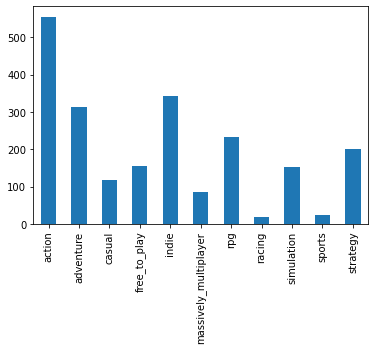

In [36]:
gen_cols = [
        'Action',
         'Adventure',
         'Casual',
         'Free to Play',
         'Indie',
         'Massively Multiplayer',
         'RPG',
         'Racing',
         'Simulation',
         'Sports',
         'Strategy',
         ]

df_col_names = [col.lower().replace('&', 'and').replace(' ', '_') for col in gen_cols]

ax = df[df_col_names].sum().plot.bar()
plt.show()

Now for the graph to help answer the question of what category has more reconmendations in it. I plot a violin graph with each game in each genre and how many recomendations it has in total.

In [37]:
dfs = []

for col in df_col_names:
    col_ratings = df.loc[df[col] == 1, 'recommendations']
    col_ratings = pd.DataFrame(zip([col] * col_ratings.shape[0], col_ratings), columns=['category', 'recommendations'])
    dfs.append(col_ratings)

ratings = pd.concat(dfs, axis=0)
ratings.reset_index(drop=True, inplace=True)

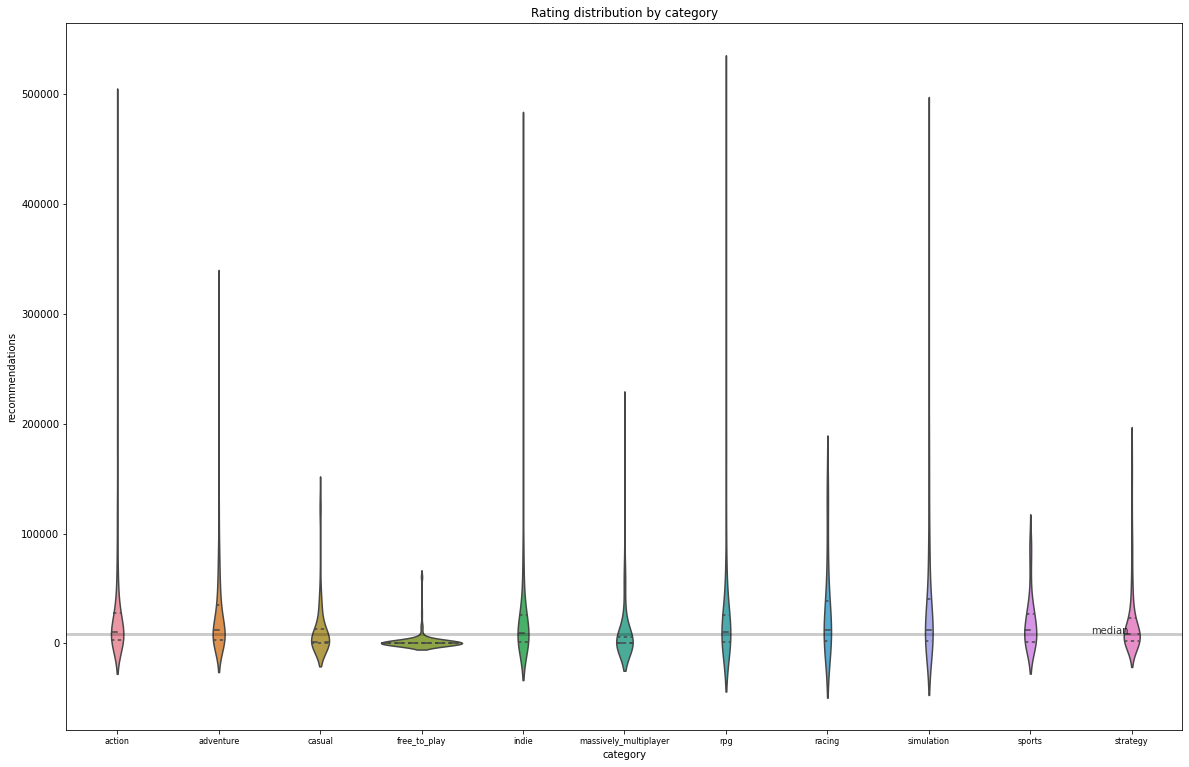

In [39]:
fig, ax = plt.subplots(figsize=(20,13))
ratings = ratings[ratings['recommendations'] < .5e6]
sns.violinplot(x='category', y='recommendations', data=ratings, inner='quartile', ax=ax)
ax.axhline(ratings.recommendations.median(), color='k', lw=3, alpha=.2)
ax.text(9.6, ratings.recommendations.median()-1, 'median', color='black', alpha=.8) 

ax.tick_params(axis='x', labelsize=8)
ax.set_title("Rating distribution by category");
plt.show()